In [1]:
import os
import ot
import json
import pprint
import networkx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from utils.preprocessing import feature_scaling
from utils.preprocessing import feature_normalization
from utils.plot import generate_hierarchical_graph_json

from domain_adaptation import compute_mass_flow
from domain_adaptation import undesired_mass_flow_index

plt.rcParams['mathtext.fontset'] = 'custom'  
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'  
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'  
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'  
plt.rcParams['font.size'] = 16  
plt.rcParams['mathtext.fontset'] = 'stix'  
plt.rcParams['font.family'] = 'STIXGeneral' 

plt.style.use('science')

palette = [
    'royalblue',
    'firebrick',
    'darkgoldenrod',
    'darkseagreen',
    'grey',
    'darkslategray',
    'crimson',
    'midnightblue',
    'saddlebrown',
    'orange',
    'seagreen',
    'dodgerblue',
    'black'
]

Using TensorFlow backend.


In [31]:
# First case: low lambda, good performance
mu1 = np.array([3, 0])
mu2 = np.array([0, 3])
mu3 = np.array([0, 5])
mu4 = np.array([3, 5])

cov1 = np.array([[0.3, 0.1], [0.1, 0.3]])
cov2 = np.array([[0.3, -0.15], [-0.15, 0.3]])
cov3 = np.array([[0.3, 0.0], [0.0, 0.05]])
cov4 = np.array([[0.3, -0.1], [-0.1, 0.05]])

x1 = np.random.multivariate_normal(mu1, cov1, size=10)
x2 = np.random.multivariate_normal(mu2, cov2, size=10)
x3 = np.random.multivariate_normal(mu3, cov3, size=10)
x4 = np.random.multivariate_normal(mu4, cov4, size=10)

In [32]:
X = np.concatenate([x1, x2, x3, x4], axis=0)
y = np.concatenate([np.array([0] * len(x1)), np.array([1] * len(x2)), np.array([1] * len(x3)), np.array([0] * len(x4))])
d = np.concatenate([np.array([0] * (len(x1) + len(x2))), np.array([1] * (len(x3) + len(x4)))])
Xs = X[np.where(d == 0)[0]]
ys = y[np.where(d == 0)[0]]
Xt = X[np.where(d == 1)[0]] 
yt = y[np.where(d == 1)[0]] 
a = ot.unif(Xs.shape[0])
b = ot.unif(Xt.shape[0])
C = ot.dist(Xs, Xt)
C = C / np.max(C)
G1 = ot.sinkhorn(a, b, C, reg=1e-3)
TXs = Xt.shape[0] * np.dot(G1, Xt)

In [33]:
clf = SVC(kernel='linear')
clf.fit(X, y)
yp = clf.predict(X)
print('Joint Risk: {}'.format(np.mean(np.abs(yp - y))))

clf.fit(Xs, ys)
yp = clf.predict(Xt)
print('Target Risk: {}'.format(np.mean(np.abs(yp - yt))))

clf.fit(TXs, ys)
yp = clf.predict(Xt)
print('[TL] Target Risk: {}'.format(np.mean(np.abs(yp - yt))))


Joint Risk: 0.0
Target Risk: 0.5
[TL] Target Risk: 0.0


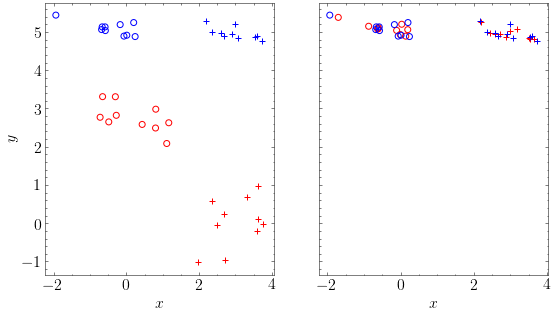

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=True)
s1 = axes[0].scatter(Xs[np.where(ys == 0)[0], 0], Xs[np.where(ys == 0)[0], 1], color='r', marker='+')
s2 = axes[0].scatter(Xs[np.where(ys == 1)[0], 0], Xs[np.where(ys == 1)[0], 1], facecolors='none', edgecolor='r')
s1 = axes[0].scatter(Xt[np.where(yt == 0)[0], 0], Xt[np.where(yt == 0)[0], 1], color='b', marker='+')
s2 = axes[0].scatter(Xt[np.where(yt == 1)[0], 0], Xt[np.where(yt == 1)[0], 1], facecolors='none', edgecolor='b')
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')

s1 = axes[1].scatter(TXs[np.where(ys == 0)[0], 0], TXs[np.where(ys == 0)[0], 1], color='r', marker='+')
s2 = axes[1].scatter(TXs[np.where(ys == 1)[0], 0], TXs[np.where(ys == 1)[0], 1], facecolors='none', edgecolor='r')
s1 = axes[1].scatter(Xt[np.where(yt == 0)[0], 0], Xt[np.where(yt == 0)[0], 1], color='b', marker='+')
s2 = axes[1].scatter(Xt[np.where(yt == 1)[0], 0], Xt[np.where(yt == 1)[0], 1], facecolors='none', edgecolor='b')
axes[1].set_xlabel('$x$')

plt.savefig('./Figures/Ch5/LowLambda.pdf', transparent=True)

In [35]:
# Third Case: High lambda, poor performance
mu1 = np.array([3, 0])
mu2 = np.array([0, 0])
mu3 = np.array([0, 5])
mu4 = np.array([3, 5])

cov1 = np.array([[0.3, 0.1], [0.1, 0.3]])
cov2 = np.array([[0.3, -0.15], [-0.15, 0.3]])
cov3 = np.array([[0.3, 0.0], [0.0, 0.05]])
cov4 = np.array([[0.3, -0.1], [-0.1, 0.05]])

x1 = np.random.multivariate_normal(mu1, cov1, size=10)
x2 = np.random.multivariate_normal(mu2, cov2, size=10)
x3 = np.random.multivariate_normal(mu4, cov4, size=10)
x4 = np.random.multivariate_normal(mu3, cov3, size=10)

In [36]:
X = np.concatenate([x1, x2, x3, x4], axis=0)
y = np.concatenate([np.array([0] * len(x1)), np.array([1] * len(x2)), np.array([1] * len(x3)), np.array([0] * len(x4))])
d = np.concatenate([np.array([0] * (len(x1) + len(x2))), np.array([1] * (len(x3) + len(x4)))])
Xs = X[np.where(d == 0)[0]]
ys = y[np.where(d == 0)[0]]
Xt = X[np.where(d == 1)[0]] 
yt = y[np.where(d == 1)[0]] 
a = ot.unif(Xs.shape[0])
b = ot.unif(Xt.shape[0])
C = ot.dist(Xs, Xt)
C = C / np.max(C)
G2 = ot.sinkhorn(a, b, C, reg=1e-2)
TXs = Xs.shape[0] * np.dot(G2, Xt)

In [37]:
clf = SVC(kernel='linear')
clf.fit(X, y)
yp = clf.predict(X)
print('Joint Risk: {}'.format(np.mean(np.abs(yp - y))))

clf.fit(Xs, ys)
yp = clf.predict(Xt)
print('Target Risk: {}'.format(np.mean(np.abs(yp - yt))))

clf.fit(TXs, ys)
yp = clf.predict(Xt)
print('[TL] Target Risk: {}'.format(np.mean(np.abs(yp - yt))))


Joint Risk: 0.25
Target Risk: 0.5
[TL] Target Risk: 1.0


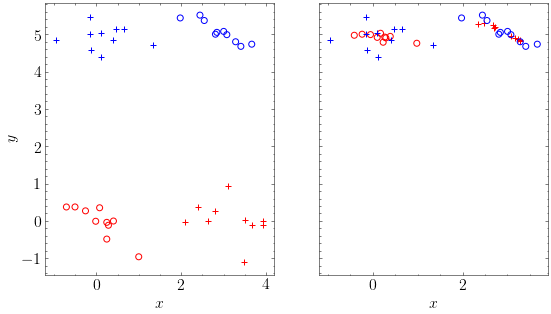

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=True)
s1 = axes[0].scatter(Xs[np.where(ys == 0)[0], 0], Xs[np.where(ys == 0)[0], 1], color='r', marker='+')
s2 = axes[0].scatter(Xs[np.where(ys == 1)[0], 0], Xs[np.where(ys == 1)[0], 1], facecolors='none', edgecolor='r')
s1 = axes[0].scatter(Xt[np.where(yt == 0)[0], 0], Xt[np.where(yt == 0)[0], 1], color='b', marker='+')
s2 = axes[0].scatter(Xt[np.where(yt == 1)[0], 0], Xt[np.where(yt == 1)[0], 1], facecolors='none', edgecolor='b')
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')

s1 = axes[1].scatter(TXs[np.where(ys == 0)[0], 0], TXs[np.where(ys == 0)[0], 1], color='r', marker='+')
s2 = axes[1].scatter(TXs[np.where(ys == 1)[0], 0], TXs[np.where(ys == 1)[0], 1], facecolors='none', edgecolor='r')
s1 = axes[1].scatter(Xt[np.where(yt == 0)[0], 0], Xt[np.where(yt == 0)[0], 1], color='b', marker='+')
s2 = axes[1].scatter(Xt[np.where(yt == 1)[0], 0], Xt[np.where(yt == 1)[0], 1], facecolors='none', edgecolor='b')
axes[1].set_xlabel('$x$')

plt.savefig('./Figures/Ch5/HighLambda.pdf', transparent=True)

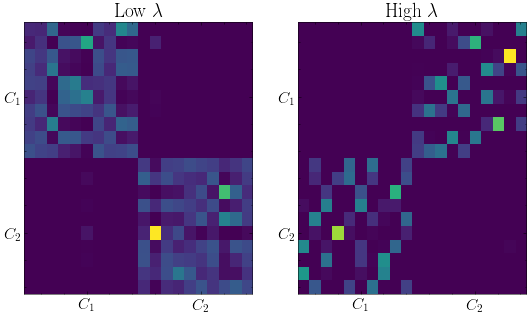

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

axes[0].imshow(G2, cmap='viridis', aspect='auto')
axes[0].set_xticks([5, 15])
axes[0].set_xticklabels(['$C_{1}$', '$C_{2}$'])
axes[0].set_yticks([5, 15])
axes[0].set_yticklabels(['$C_{1}$', '$C_{2}$'])
axes[0].set_title('Low $\lambda$')
axes[1].imshow(G1, cmap='viridis', aspect='auto')
axes[1].set_xticks([5, 15])
axes[1].set_xticklabels(['$C_{1}$', '$C_{2}$'])
axes[1].set_yticks([5, 15])
axes[1].set_yticklabels(['$C_{1}$', '$C_{2}$'])
axes[1].set_title('High $\lambda$')
plt.savefig('./Figures/Ch5/TransportPlans.pdf', transparent=True)